# 交通システム分析 12/8 課題
## Joshua Teguh Santoso / B7TB1702

In this homework, I tried to make a many-to-many (M2M) OD-pairs static user equilibrium traffic assignment program which the data obtain from [1]. I used the Frank-Wolfe algorithm in this program in the attempt to solve UE problem in which it can be represented as an equivalen convex programming problem effectively and efficiently.

### Convergence test
From Sheffi's textbook (1985) [2], there are 3 convergence test that have to be fulfilled to terminate the algorithm which are:

1. The rate of change of the objective function denoted by $Z$

$$
\frac{Z^{n-1}-Z^n}{Z^{n-1}} \leq \epsilon
$$

2. The rate of change in link flows denoted by $x_ij$ where $i,j$ belongs to set of links $\mathcal{L}$

$$
\frac{\sqrt{\sum_{ij \in \mathcal{L}} (x^n_{ij} - x^{n-1}_{ij})^2}}{\sum_{ij \in \mathcal{L}} x^{n-1}_{ij}} \leq \epsilon
$$

3. The rate of change of the shortest travel time denoted by $\pi$ of each OD pairs ($rs$) at iteration $n$.

$$
\sum_{rs}\frac{|\pi^n_{rs} - \pi^{n-1}_{rs}|}{\pi^n_{rs}} \leq \epsilon
$$

where $\epsilon$ is an infinitesimal number.

### Data visualisation

In order for the obtained data can be easily understood, the obtained data is visualised in the form of similar to those in Google Maps. The visualised data has the form of the graph network and the link traffic state whether it is free flow, light traffic, moderate traffic or blockage. From this visualisation, traffic planners can manage the traffic demand of OD pairs so that less congestion will occur. The link traffic state is determined by a parameter called Relative Congestion Index (RCI) [3] which is defined as:

$$\text{RCI} = \frac{T_{ac}-T_{ff}}{T_{ff}} $$

where $T_{ac}$ is the actual travel time/cost and $T_{ff}$ is the free flow travel time. The RCI of 0 denotes free flow traffic, and the values greater than two (>2) show a significant congestion level. I divided the traffic state into 6 states which are:

| RCI | State | Colour |
| :---: | :---: | :---: |
| $0\leq\text{RCI}<0.005$ | Free-flow traffic | lawngreen |
| $0.005\leq\text{RCI}<0.5$ | Light traffic | green |
| $0.5\leq\text{RCI}<1.0$ | Medium traffic | yellow |
| $1.0\leq\text{RCI}<1.5$ | Moderate traffic | orange |
| $1.5\leq\text{RCI}<2.0$ | Heavy traffic | red |
| $\text{RCI}\geq2.0$ | Blockage | darkred |

## References
[1] Transportation Networks for Research Core Team. *Transportation Networks for Research.* https://github.com/bstabler/TransportationNetworks. Accessed 2020/12/12.

[2] Sheffi, Y. (1985). *Urban Transportation Networks.* Englewood Cliffs (New Jersey): Prentice-Hall.

[3] Afrin, T., & Yodo, N. (2020). *A Survey of Road Traffic Congestion Measures towards a Sustainable and Resilient Transportation System.* Sustainability, 12(11), 4660. doi: 10.3390/su12114660

In [1]:
import numpy as np
import pandas as pd
import scipy as sp 
from scipy import sparse, optimize
from operator import itemgetter,attrgetter
from itertools import product, chain
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import glob, re, heapq, math, pprint, time

max_itr = 500 #Maximum iteration of the algorithm permitted
TOL = 1e-6 #Tolerance number
inf = 1e6 #Infinity number

In [2]:
class Network:
    #
    # Initializer
    #
    def __init__(self, root='', dir_name='', net=None, trips=None, coord=None, graph=None):
        if net is None or trips is None:
            self.setup(root, dir_name, graph)
            return
        self.net, self.trips, self.graph = net, trips, graph

        # Initialising the node and link data
        init = list(net.iloc[:,0].astype('int').values)
        term = list(net.iloc[:,1].astype('int').values)
        self.links = list((zip(init,term)))
        self.nodes = sorted(list(set(chain.from_iterable(self.links))))
        self.N = len(self.nodes) # Number of nodes
        self.L = len(self.links) # Number of links
        self.nextNode = {i: [l[1] for l in self.links if l[0] == i] for i in self.nodes} # List of neighbor nodes of a paricular node

        # Initialiasing the parameter of links in the networks
        self.capacity = {self.links[i]: net.iloc[:,2].values.astype('float')[i] for i in range(len(self.links))}
        self.fftt = {self.links[i]: net.iloc[:,4].values.astype('float')[i] for i in range(len(self.links))}
        self.b = {self.links[i]: net.iloc[:,5].values.astype('float')[i] for i in range(len(self.links))}
        self.power = {self.links[i]: net.iloc[:,6].values.astype('float')[i] for i in range(len(self.links))}

        # Creating a list for coordinates if it is available
        if coord is not None:
            self.nodeCoord = {self.nodes[i]: (coord.iloc[:,1].values.astype('int')[i],coord.iloc[:,2].values.astype('int')[i]) for i in range(self.N)}

    #
    # Data input processing
    #
    def setup(self, root, dir_name,graph):
        net_fname = glob.glob('%s/%s/*_net*' % (root, dir_name))[0]
        trips_fname = glob.glob('%s/%s/*_trips*' % (root, dir_name))[0]
        print("net file:\t%s" % net_fname)
        print("trips file:\t%s" % trips_fname)
        net = read_net(net_fname)
        trips = read_trips(trips_fname)

        #Finding coordinate file (if requested)
        if graph == True:
            try:
                coord_fname = glob.glob('%s/%s/*_node*' % (root,dir_name))[0]
                print("coord file:\t%s" % coord_fname)
                coord = read_coord(coord_fname)
                self.__init__(net=net, trips=trips, coord=coord, graph=graph)
            except IndexError:
                print(" '*_node*' file cannot be found ") # Prints an erorr message if file is not found
                self.__init__(net=net, trips=trips, graph=graph)
        else:
            self.__init__(net=net, trips=trips, graph=graph)

    #
    # Link cost function as defined by the BPR function
    #    
    def t(self, x=None):
        if x is None:
            return self.fftt
        return {l: self.fftt[l]*(1 + self.b[l]*(x[l]/self.capacity[l])**self.power[l]) for l in self.links} 

    #
    # The integral of link cost function
    #
    def T(self, x):
        return {l: self.fftt[l]*x[l]*(1+self.b[l]/(1+self.power[l])*(x[l]/self.capacity[l])**self.power[l]) for l in self.links}

    #
    # The objective function of the equivalent convex programming problem
    #
    def Z(self, x):
        return sum(self.T(x).values())

    #
    # Dijkstra algorithm
    #
    def dijkstra(self,w,orig,returnPred=None):
        pi = {i: inf for i in self.nodes} # List for cost to reach a node from certain origin $c_i$
        pred = {i: None for i in self.nodes} # List of predecessor node at a paricular node for mapping routes from a certain origin
        nodesNondet = {i: True for i in self.nodes} # List of non-determined nodes

        # Determining the cost and predecessor node at origin node
        pi[orig] = 0.0 
        pred[orig] = -9999

        while True:
            # Finding a node with smallest cost in the non-determined list
            minCost = inf
            minCostNode = None
            for node in nodesNondet.keys():
                if minCost > pi[node]:
                    minCost = pi[node]
                    minCostNode = node

            # The node with smallest cost becomes 'determined'. Hence deleted from the list.
            del nodesNondet[minCostNode]

            # Breaking the loop if there's no non-determined nodes left
            if len(nodesNondet) == 0:
                break
            
            # Updating the cost for the neighbor nodes of the smallest cost node
            for nextNode in self.nextNode[minCostNode]:
                newCost = minCost + w[(minCostNode,nextNode)]
                if newCost < pi[nextNode]:
                    pi[nextNode] = newCost
                    pred[nextNode] = minCostNode

        # Returning cost (and predecessor if requested)
        if returnPred == True:
            return pi, pred
        else:
            return pi

    #
    # Calculation of shortest travel time for every O-D pairs (for convergence test)
    #
    def ShortestTravelTime(self,w):
        ret = {orig: None for orig in self.trips.keys()}
        for orig in self.trips.keys():
            ret[orig] = self.dijkstra(w,orig)
        return ret

    #
    # All-or-Nothing assignment
    #

    # All-or-Nothing assignment for a single origin
    def AoN_O2M(self,w,orig):
        pi,pred = self.dijkstra(w,orig,returnPred=True)

        x = {l: 0.0 for l in self.links}
        X = {i: 0.0 for i in self.nodes}

        for j, pi_j in sorted(pi.items(), key=itemgetter(1),reverse=True):
            i = pred[j]
            if i == -9999:
                continue
            x[i,j] += X[j]
            if j in self.trips[orig]:
                x[i,j] += self.trips[orig][j]
            X[i] += x[i,j]
        return x

    # All-or-Nothing assignment for every origin
    def AoN(self,w):
        x = {l: 0.0 for l in self.links}
        for orig in self.trips:
            res = self.AoN_O2M(w,orig)
            for l in self.links:
                x[l] += res[l]
        return x

    #
    # Linear search for the optimal step size (α) by using Golden Section method
    #
    def FindAlpha(self,x,y):
        # Defining the golden ratio
        gr = (math.sqrt(5) - 1) / 2

        # The limits of the step size (0<=α<=1)
        a = 0
        b = 1

        xL = (b-a)*(1-gr) + a # Initial value of the left-hand side dividing point 
        xR = (b-a)*gr + a # Initial value of the right-hand side dividing point 

        # The iteration will run until the convergence test is fulfilled
        while abs(b-a) > TOL:

            # Calculating the new temporary solution based on the interior points
            xL_opt = {l: (1-xL)*x[l]+xL*y[l] for l in self.links}
            xR_opt = {l: (1-xR)*x[l]+xR*y[l] for l in self.links}

            # Calculating the objective function from the new temporary solution
            funcL = self.Z(xL_opt)
            funcR = self.Z(xR_opt)

            # Calculation based on the golden section method
            if funcL <= funcR:
                b = xR
                xR = xL
                xL = (b-a)*(1-gr) + a
            else:
                a = xL
                xL = xR
                xR = (b-a)*gr + a
        
        return (b+a)/2
    
    #
    # Main Algorithm
    #
    def SolveUE(self):
        # Initialising the variables
        Z, Z_rate, x_rate, pi_rate, alpha_list = ([] for i in range(5))
        pi0_arr = np.array([]) # It is set to np.array for calculation
        x = {l: None for l in self.links}
        x0 = self.AoN(self.t())
        pi0 = self.ShortestTravelTime(self.t())

        # Changing from dictionary to np.array
        for orig in self.trips.keys():
            pi0_arr = np.append(pi0_arr, np.fromiter(pi0[orig].values(), dtype='float'))

        Z.append(self.Z(x0))

        # Main Loop
        for itr in range(max_itr):
            
            # Obtaining the auxliary solution from the all-or-nothing assignment
            y = self.AoN(self.t(x0))

            # Finding the optimal step size
            alpha = self.FindAlpha(x0,y)
            alpha_list.append(alpha)

            # Updating the tentative solution
            for l in self.links:
                x[l] = x0[l] + alpha*(y[l]-x0[l])
            pi = self.ShortestTravelTime(self.t(x))
            pi_arr = np.array([])
            for orig in self.trips:
                pi_arr = np.append(pi_arr, np.fromiter(pi[orig].values(), dtype='float'))
            
            Z.append(self.Z(x))
            
            # Calculation of the change rates for the convergence test
            Z_rate.append((-Z[-1]+Z[-2])/Z[-2])
            pi_rate.append(sum(abs(pi_arr[pi0_arr>0] - pi0_arr[pi0_arr>0])/pi0_arr[pi0_arr>0]))
            x_rate.append(math.sqrt(sum((x0[l]-x[l])**2 for l in self.links))/sum(x0.values()))

            # Convergence test
            if Z_rate[-1] < TOL or x_rate[-1] < TOL or pi_rate[-1] < TOL:
                break

            # Memorizing the current solution
            x0 = x.copy()
            pi0_arr = pi_arr.copy()

        # Calculating the cost from the final solution
        t = self.t(x)
        
        # Preparing the data for the output
        x_ser = pd.Series(x)
        cap_ser = pd.Series(self.capacity)
        t_ser = pd.Series(t)
        fftt_ser = pd.Series(self.fftt)

        # Calculating the link flow percentage of the link capacity
        perc = {l: round(x[l]/self.capacity[l]*100, 2) for l in self.links}
        perc_ser = pd.Series(perc)
        
        # Calculate the Relative Congestion Index (RCI)
        RCI = {l: (t[l]-self.fftt[l])/self.fftt[l] for l in self.links}
        RCI_ser = pd.Series(RCI)
        
        # Output data table
        res = pd.DataFrame({'Link Flow': x_ser.values,
                             'Capacity': cap_ser.values,
                             'Flow % of capacity': perc_ser, 
                             'Link Cost':t_ser.values,
                             'FFTT': fftt_ser.values, 
                             'RCI': RCI_ser.values})#,
                            #index=self.links)

        # Plotting the performance of the algorithm
        perf = plt.figure()
        ax = perf.add_subplot(1,2,1)
        ax.plot(Z,'C0', label="Z")
        ax.legend()
        ax.set_yscale('linear')
        ax1 = perf.add_subplot(1,2,2)
        ax1.plot(Z_rate, 'C1',label="Z rate")
        ax1.plot(x_rate, 'C2', label="x rate")
        ax1.plot(pi_rate, 'C3', label="$\pi$ rate")
        ax1.legend()
        ax1.set_yscale('log')
        perf.suptitle('Performance')
        perf.show()
        
        #
        # Plotting the map of the network with congestion-level for better visualisation (if requested)
        #
        if self.graph == True:
            try:
                self.nodeCoord
            except AttributeError:
                print('Since coordinate file does not exist, then the map cannot be displayed')
            else:
                clrs = ['lawngreen','green','yellow','orange','red','darkred']
                labels = ['free flow','light traffic','','moderate','','blockage']
                grph = nx.DiGraph(directed=True)
                grph.add_nodes_from(self.nodeCoord.keys())
                grph.add_edges_from(self.links,color=clrs[0],weight=4)

                for l in self.links:
                    if RCI[l] >= 0.005 and RCI[l] < 0.5:
                        grph[l[0]][l[1]]['color'] = clrs[1]
                    elif RCI[l] >= 0.5 and RCI[l] < 1.0:
                        grph[l[0]][l[1]]['color'] = clrs[2]
                    elif RCI[l] >= 1.0 and RCI[l] < 1.5:
                        grph[l[0]][l[1]]['color'] = clrs[3]
                    elif RCI[l] >= 1.5 and RCI[l] < 2.0:
                        grph[l[0]][l[1]]['color'] = clrs[4]
                    elif RCI[l] >= 2.0:
                        grph[l[0]][l[1]]['color'] = clrs[5]
                
                colors = [grph[l[0]][l[1]]['color'] for l in self.links]
                weights = [grph[l[0]][l[1]]['weight'] for l in self.links]

                plt.figure(figsize=(8,10))
                nx.draw(grph,self.nodeCoord,
                    with_labels = True, 
                    node_color='white', 
                    edge_color=colors, 
                    width=weights, 
                    connectionstyle='arc3, rad = 0.1')
                
                # Plotting the legend
                def make_proxy(clr,mappable,**kwargs):
                    return Line2D([0,1],[0,1],color=clr, **kwargs)

                proxies = [make_proxy(clr,grph,lw=3) for clr in clrs]
                plt.legend(proxies,labels)

                # Setting up the node outline color
                ax= plt.gca()
                ax.collections[0].set_edgecolor("#000000")
                plt.axis('off')

                plt.show()
        else:
            pass
        
        return res

#
# Read trip data from ***_trips.tntp
#
def read_trips(fname):
    with open(fname, 'r') as f:
        trips = {}
        all_rows = f.read()
        blocks = all_rows.split('Origin')[1:]
        #print(all_rows)
        for k in range(len(blocks)):
            orig_dest = blocks[k].split('\n')
            orig = int(orig_dest[0])
            trips_to_dest = {}
            for d in ''.join(orig_dest[1:]).split(';'):
                m = re.search(r"(.+):(.+)", d)
                if m:
                    dest, val = int(m.group(1)), float(m.group(2))
                    trips_to_dest[dest] = val
            trips[orig] = trips_to_dest
        return trips

#
# Read network data from ***_net.tntp
#
def read_net(fname):
    skip_rows = 0
    with open(fname, 'r') as f:
        while True:
            line = f.readline()
            if ('~') in line:
                break
            else:
                skip_rows += 1
    with open(fname, 'r') as f:
        net = pd.read_csv(f, sep="\t", skiprows=skip_rows)
        net.dropna(how="all", inplace=True)
        # lowercase and strip unnecessary spaces for each column
        net.columns = map(str.lower, net.columns)
        net.columns = map(str.strip, net.columns)
        # Drop the first column if it is redundant
        while 'init node' not in net.columns[0] and 'tail' not in net.columns[0] and 'from' not in net.columns[0]:
            net.drop(net.columns[0], axis='columns', inplace=True)
        # Drop the redundant the last column
        net.drop(net.columns[-1], axis='columns', inplace=True)
        return net

#
# Read coordinate data from ***_node.tntp
#
def read_coord(fname):
    with open(fname, 'r') as f:
        Coord = pd.read_csv(f, sep="\t")
        Coord.dropna(how="all", inplace=True)
        Coord.drop(Coord.columns[-1], axis='columns', inplace=True)
    return Coord

net file:	data/SiouxFalls\SiouxFalls_net.tntp
trips file:	data/SiouxFalls\SiouxFalls_trips.tntp
coord file:	data/SiouxFalls\SiouxFalls_node.tntp


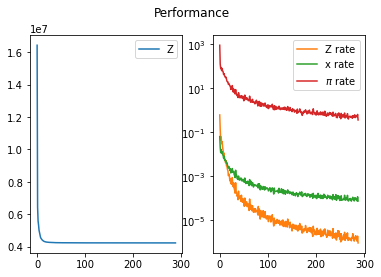

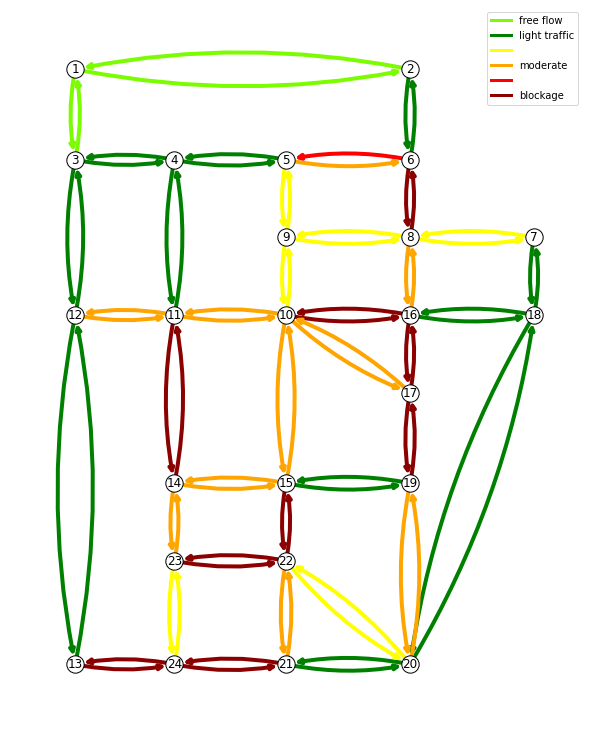

deltaT: 10.892063


Link Flow      Capacity  Flow % of capacity  Link Cost  FFTT  \
1  2    4500.197493  25900.200640               17.38   6.000820   6.0   
   3    8122.363559  23403.473190               34.71   4.008705   4.0   
2  1    4521.260057  25900.200640               17.46   6.000836   6.0   
   6    5971.654943   4958.180928              120.44   6.578158   5.0   
3  1    8101.300996  23403.473190               34.62   4.008615   4.0   
...             ...           ...                 ...        ...   ...   
23 22   9618.344030   5000.000000              192.37  12.216228   4.0   
   24   7896.915840   5078.508436              155.50   3.753907   2.0   
24 13  11108.556037   5091.256152              218.19  17.598215   4.0   
   21  10245.748003   4885.357564              209.72  11.705661   3.0   
   23   7853.655194   5078.508436              154.64   3.715789   2.0   

            RCI  
1  2   0.000137  
   3   0.002176  
2  1   0.000139  
   6   0.315632  
3  1   0.002154  
...         ...  
23 22  2.054057  
   24  0.876954  
24 13  3.399554  
   21  2.901887  
   23  0.857894  

[76 rows x 6 columns]

In [3]:
root = 'data' # Loaction of the folder containing the data
dir_name = 'SiouxFalls' # Choosing one of the network available (more on the text above)

t0 = time.time()

ntw = Network(root,dir_name,graph=True) # Loading of the data (map data visualisation can be requested from here)
res = ntw.SolveUE() # Solving user-equilibrium traffic assignment

t1 = time.time()

print('deltaT: %lf' % (t1-t0)) # Calculating the time for evaluating the performance of the program

# Showing the result data
res

<AxesSubplot:xlabel='Link'>

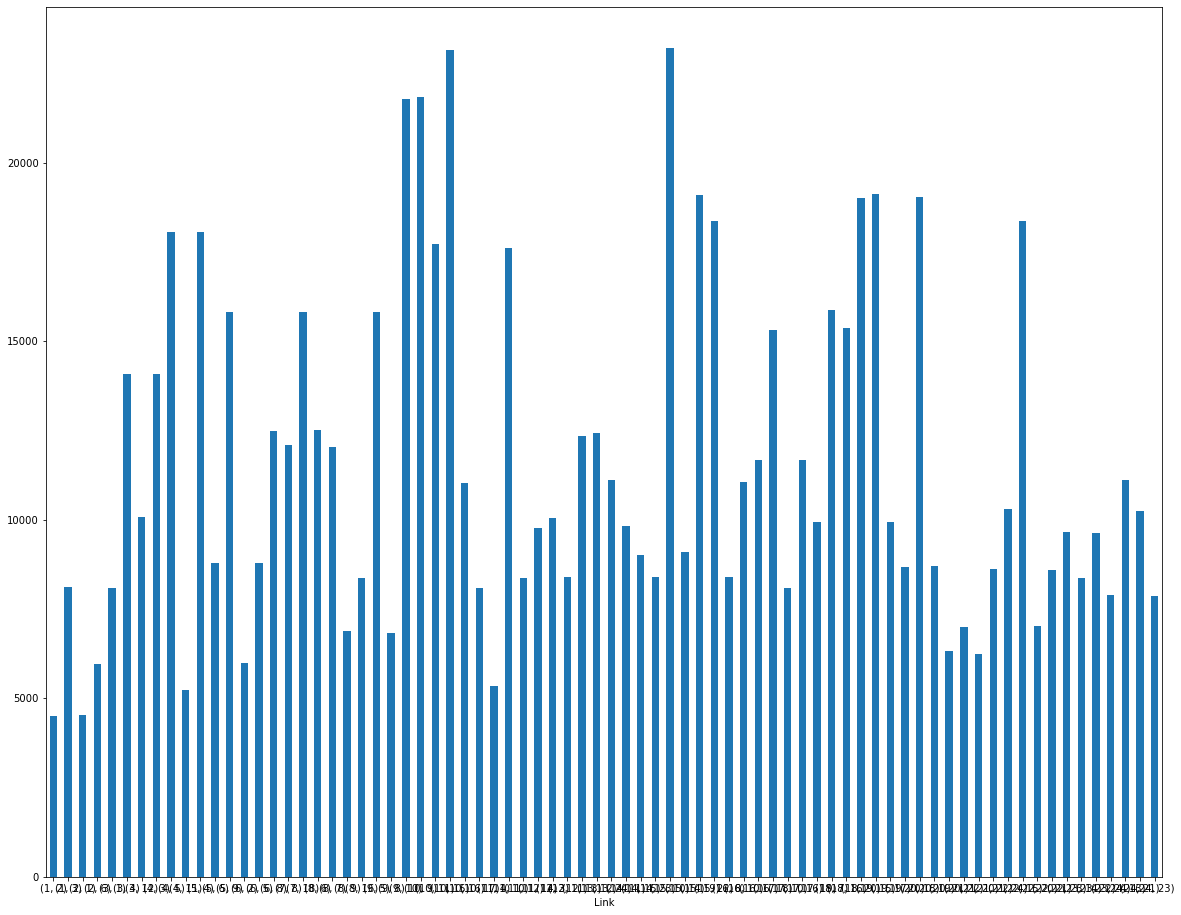

In [6]:
res['Link Flow'].plot.bar(xlabel='Link', ylabel='',rot=0, figsize=(20,16))